#### Vicky van der Wagt

# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [393]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [394]:
# Use this space for any additional import statements you need

In [395]:
# Place any addtional functions or constants you need here. 

def remove_song_title(text):
    """This functon removes the song title from lyrics, by removing any texts before
    the first newline character."""
    
    newline_index = text.find('\n')
    
    if newline_index != -1:  # Ensure newline exists in the text
        lyrics = text[newline_index+1:]
        return lyrics
    
    else:
        return text  # Return original text if newline not found
    
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    #print length of set of tokens (sets can't have duplicates)
    num_unique_tokens = len(set(tokens))
    #ratio of unique tokens to the total number of tokens
    #added if statement just incase num_tokens is 0 which would result in error
    lexical_diversity = num_unique_tokens / num_tokens if len(tokens) > 0 else 0
    #for each token, count the length (# of characters)
    num_characters = sum(len(token) for token in tokens)

    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    """This function removes null values and stopwords (sw)"""
    
    tokens = [token for token in tokens if token and token.lower() not in sw]
    
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    text = text.split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)

    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [396]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/vicky/Documents/GitHub/ADS509-Assignment2.2/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [397]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [398]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [399]:
#read in the lyrics data
lyrics_path = os.path.join(data_location, lyrics_folder)

data_list = []

# for every artist (folder) in the lyrics path...
for artist in os.listdir(lyrics_path):
    #find the artist path
    artist_path = os.path.join(lyrics_path, artist)
    if os.path.isdir(artist_path):
        # for each song in artist_path...
        for song_file in os.listdir(artist_path):
            # if text file (all lyrics should be text files)...
            if song_file.endswith('.txt'):
                # extract the song title, listed after first underscore delimiter
                song_title = song_file.split("_", 1)[1].split(".")[0]
                song_path = os.path.join(artist_path, song_file)
                with open(song_path, 'r', encoding='utf-8') as file:
                    # read the file
                    song_lyrics = file.read()
                    # append data as a dictionary to the list
                    data_list.append({'artist': artist, 'song_title': song_title, 'lyrics': song_lyrics})

# generate dataframe from the list of dictionaries
lyrics_data = pd.DataFrame(data_list)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [420]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5
my_pipeline_lyrics = [str.lower, remove_punctuation, tokenize, remove_stop]
my_pipeline_twitter = [str.lower, remove_punctuation, remove_song_title, tokenize, remove_stop]
#my_pipeline = [str.lower]


lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline_lyrics)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline_twitter)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 
#drop descriptions with no tokens, as they do not give us info for our current goals
twitter_data = twitter_data.dropna(subset=['description'])

In [422]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [423]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
830539,cher,"Small Biz owner, Husband, Dad, StoNEs fan.#45 ...","[small, biz, owner, husband, dad, stones, fan#..."
1390287,cher,"Small, woman-owned cycling cap business establ...","[small, womanowned, cycling, cap, business, es..."
1224095,cher,"Live a lot, love a few but always paddle ur ow...","[live, lot, love, always, paddle, ur, canoe, 😎]"
3854498,cher,"live, love, laugh 💛","[live, love, laugh, 💛]"
2249086,cher,📺 Download the TV One App! Watch your favorite...,"[📺, download, tv, one, app, watch, favorite, s..."
1279259,cher,"Your new favourite dark and spooky, cute and k...","[new, favourite, dark, spooky, cute, kooky, dr..."
3373088,cher,"We live, as we dream.. 18.02.2o13 LoVe #Foreve...","[live, dream, 18022o13, love, #forever, alexis..."
1711281,cher,Respect nurse.. Make them feel proud ✌❤❤,"[respect, nurse, make, feel, proud, ✌❤❤]"
3791855,cher,"tweets sobre mis pensamientos y emociones, tam...","[tweets, sobre, mis, pensamientos, emociones, ..."
822050,cher,"Do you know...what it feels like, for a girl 🎼...","[knowwhat, feels, like, girl, 🎼👑💃🏿🎧🎤]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One improvement to tokenization would be to remove blank descriptions in the preprocessing pipeline for the twitter data. I did not initially do this, but went back and implemented it because my wordmaps had 'nan' for both Robyn and Cher twitter descriptions. By removing the null values, it ensures that tokenization is performed on valid data. Another imrpovement could be to have each individual emoji as a token. Currently, if many emojis are in a row, they count as one emoji but they could eech communicate different things. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [425]:
# your code here

#gather cher descriptive statistics on the lyrics (tokens)
print("Cher Lyrics - Descriptive Statistics\n")
all_tokens_cher = lyrics_data[lyrics_data['artist'] == 'cher']['tokens'].sum()
cher_lyrics_descriptive_stats = descriptive_stats(all_tokens_cher)

#gather robyn descriptive statistics on the lyrics (tokens)

print("\n\nRobyn Lyrics - Descriptive Statistics\n")
all_tokens_robyn = lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'].sum()
cher_lyrics_descriptive_stats = descriptive_stats(all_tokens_robyn)

Cher Lyrics - Descriptive Statistics

There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.


Robyn Lyrics - Descriptive Statistics

There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.142 in the data.


Q: what observations do you make about these data? 

A: Cher's token count and character count are over double the number of Robyn's, indicating that Cher has many more total words and characters in her lyrics. This could be due to potentially longer songs, and more songs. Robyn's lyrics have a higher lexical diversity than cher, 14.2% compared to Cher's 10.3%. This indicates that Robyn uses a higher range of unique words in her lyrics, about 4% more than Cher despite Cher using more total tokens in general.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [426]:
# your code here

#prepare the four corpora (filter by artist)
lyrics_cher = (lyrics_data[lyrics_data['artist'] == 'cher'])
lyrics_robyn = (lyrics_data[lyrics_data['artist'] == 'robyn'])

twitter_cher = (twitter_data[twitter_data['artist'] == 'cher'])
twitter_robyn = (twitter_data[twitter_data['artist'] == 'robyn'])

In [429]:
def flatten_list(list_of_lists):
    """this function flatterns (combines) a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]

def token_ratios(corpus_dataframes):
    """this function takes a dataframe dictionary as input, and returns a 
    dataframe containing a column containing tokens, and additional "ratio" columns, one
    for each corpora. These "ratio" columns are calculated by taken the concentration
    of a token in one corpus, divided by the sum of that token concentration in other corpora.
    This function also filters for words that appear at least 5 times in all corpora."""
    
    # generate empty lists to store the token counts and concentrations
    corpus_token_counts = []
    corpus_concentrations = []
    # for each corpus dataframe...
    for corpus_name, corpus_df in corpus_dataframes.items():
        # Flatten the list of lists of tokens
        all_tokens = flatten_list(corpus_df['tokens'])

        # calculate token counts
        token_counts = pd.Series(all_tokens).value_counts()

        # Add corpus name prefix to token counts column name
        token_counts.name = corpus_name + '_count'

        # append token counts for the corpora to the list
        corpus_token_counts.append(token_counts)
        
        total_tokens = len(all_tokens)
        token_concentration = (token_counts/total_tokens)
        token_concentration.name = corpus_name + '_concentration'
        corpus_concentrations.append(token_concentration)
  
    # concatenate results from each corpora into one dataframe
    token_counts_df = pd.concat(corpus_token_counts, axis=1, sort=True)
    
    corpus_concentrations_df = pd.concat(corpus_concentrations, axis=1, sort=True)

    #fill missing values with 0
    token_counts_df = token_counts_df.fillna(0)
    corpus_concentrations_df = corpus_concentrations_df.fillna(0)

    # calculate the total count of each token across all corpora
    token_counts_df['total_count'] = token_counts_df.sum(axis=1)

    # filter to ensure that tokens each appear at least 5 times in each corpora
    token_counts_df = token_counts_df[token_counts_df.min(axis=1) >= 5]

    # reset index to generate token column
    token_counts_df.reset_index(inplace=True)
    corpus_concentrations_df.reset_index(inplace=True)

    # Rename the 'index' column to 'token'
    token_counts_df.rename(columns={'index': 'token'}, inplace=True)
    corpus_concentrations_df.rename(columns={'index': 'token'}, inplace=True)

    token_counts_df = pd.merge(token_counts_df, corpus_concentrations_df, on='token', how='left')
    
     # get all columns ending with 'concentration'
    concentration_columns = [col for col in token_counts_df.columns if col.endswith('_concentration')]

    # calculate the sum of concentrations for all concentration columns
    token_counts_df['concentration_sums'] = token_counts_df[concentration_columns].sum(axis=1)

    # for each concentration column...
    for concentration_col in concentration_columns:
        # calculate the ratio for the current concentration column
        ratio_col_name = concentration_col.replace('_concentration', '_ratio')
        token_counts_df[ratio_col_name] = token_counts_df[concentration_col] / (token_counts_df['concentration_sums'] - token_counts_df[concentration_col])
    
    # choose to keep the tokens column and the ratio columns in the ouput
    ratio_columns = [col for col in token_counts_df.columns if col.endswith('_ratio')]
    token_counts_df = token_counts_df[['token'] + ratio_columns]

    return token_counts_df

In [430]:
#generate dictionary containing our corpora dataframes

corpus_dataframes = {
    'lyrics_cher': lyrics_cher,
    'lyrics_robyn': lyrics_robyn,
    'twitter_cher': twitter_cher,
    'twitter_robyn': twitter_robyn
}

# generate dataframe containing column of tokens, and associated concentration ratios
corpus_token_ratios = token_ratios(corpus_dataframes)

def get_top_tokens_by_ratio(dataframe):
    """ This function returns the top 10 values in each column that ends with _ratio."""
    # create empty results dataframe
    top_tokens_by_ratio = {}

    # for each column in the dataframe...
    for column in dataframe.columns:
        # check if column name ends with 'ratio'
        if column.endswith('_ratio'):
            # get top 10 max values along with their corresponding tokens
            top_tokens = dataframe.nlargest(10, column)[['token', column]]
            top_tokens_by_ratio[column] = top_tokens

    return top_tokens_by_ratio

top_ratios = get_top_tokens_by_ratio(corpus_token_ratios)

# print results
for column, top_tokens_df in top_ratios.items():
    print(f"Top 10 tokens for column '{column}':")
    print(top_tokens_df)

Top tokens:
       token  lyrics_cher_ratio  lyrics_robyn_ratio  twitter_cher_ratio  \
0         88           0.176571            4.745301            0.008438   
1     afraid           0.696641            0.593611            0.145024   
2       aint           1.037751            0.767312            0.032863   
3      alone           2.188769            0.270693            0.053642   
4    alright           0.136239            5.598446            0.016364   
..       ...                ...                 ...                 ...   
371     yeah           0.314430            2.566380            0.022011   
372      yes           1.455924            0.194161            0.150802   
373    youll           0.883752            0.829141            0.042366   
374    youre           0.777361            1.098883            0.019387   
375    youve           1.120878            0.741122            0.022346   

     twitter_robyn_ratio  
0               0.015863  
1               0.099203  
2     

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The words with higher ratios for Cher's lyrics are often associated with breakups or leaving such as "without", "door", "tears","enough", and "strong." On the other hand, the output for Robyn's lyrics relate to dancing and moving such as "shake", "dance", "beat." Top words for twitter descriptions for both Cher and Robyn fans seem like more common and general words. One interesting observation is that 88 made the list for Robyn lyrics, indicating it was present in at least 5 tokens in each of the corpora. After researching, I found that both Robyn and Cher have a song called '88 degrees.'

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [433]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [434]:
#run the count_words function on each dataframe, and then convert each dataframe to series
freq_df_lyrics_cher = count_words(lyrics_cher)
freq_series_lyrics_cher = freq_df_lyrics_cher['freq']

freq_df_lyrics_robyn = count_words(lyrics_robyn)
freq_series_lyrics_robyn = freq_df_lyrics_robyn['freq']

freq_df_twitter_cher = count_words(twitter_cher)
freq_series_twitter_cher = freq_df_twitter_cher['freq']

freq_df_twitter_robyn = count_words(twitter_robyn)
freq_series_twitter_robyn = freq_df_twitter_robyn['freq']

### Wordclouds

#### Cher lyrics

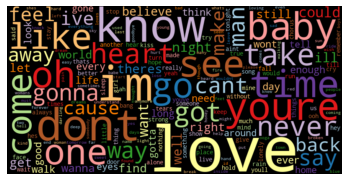

In [435]:
lyrics_cher_wordcloud = wordcloud(freq_series_lyrics_cher)

#### Robyn lyrics

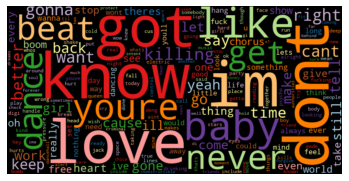

In [436]:
lyrics_robyn_wordcloud = wordcloud(freq_series_lyrics_robyn)

#### Cher twitter follower descriptions

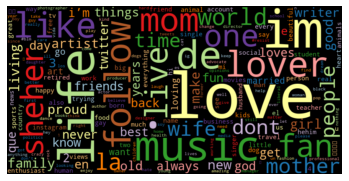

In [437]:
twitter_cher_wordcloud = wordcloud(freq_series_twitter_cher)

#### Robyn twitter follower descriptions

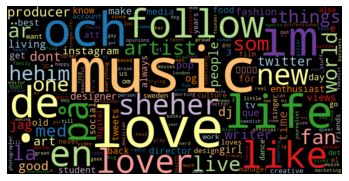

In [438]:
twitter_robyn_wordcloud = wordcloud(freq_series_twitter_robyn)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Love is mentioned often in all of them. The song lyrics from Cher and Robyn also often use words baby, and heart, indicating that many of their songs may have to do with love. The word maps from the twitter followers mention words that describe people more, such as "wife", "mom", "sheher" (presumable she/her beforehand), and "fan." Both have large "music" words, indicating that both of their followers mention music often in their bio and are therefore passionate about music.